# 3. Data resources

## 3.1 Data sources

#### Dataset directory setting to use kagglehub module

In [1]:
import site
import sys
sys.path.append("../../.local/lib/python3.13/site-packages")

#### Dataset download

In [2]:
import kagglehub
info_path = kagglehub.dataset_download("rehandl23/fifa-24-player-stats-dataset")
img_path = kagglehub.dataset_download("soumendraprasad/fifa-2022-all-players-image-dataset")

#### Dataset to csv file for better handling

In [1]:
import os, glob
import pandas as pd

csv_file = glob.glob(os.path.join(info_path, "*.csv"))
csv_file = csv_file[0]
df_info_test = pd.read_csv(csv_file, encoding="latin-1")
print(df_info_test.head(3))

NameError: name 'info_path' is not defined

## 3.2 Data Preprocessing and Name Matching

#### Functions for encoding and preprocessing (image files)

In [4]:
def fix_encoding(text):
    if not isinstance(text, str):
        return text
    try:
        return text.encode("latin1").decode("utf8")
    except Exception:
        return text

def normalize_name(x):
    if not isinstance(x, str):
        return x

    x = fix_encoding(x).strip()

    x = x.replace(os.sep, " ")
    x = re.sub(r"[\\/]", " ", x)

    x = re.sub(r"\(.*?\)", "", x)

    x = re.sub(r"(?i)\bimages[_\s-]*", "", x)
    x = re.sub(r"(?i)\bplayers[_\s-]*", "", x)
    x = re.sub(r"(?i)\bgroup[_\s-]*[a-h]?\b", "", x)

    x = x.replace("_", " ").replace("-", " ")
    x = re.sub(r"\s+", " ", x).strip()

    return x.lower()

#### Encoding Handling (height)

In [5]:
try:
    df_info = pd.read_csv(csv_file, encoding="utf-8")
except UnicodeDecodeError:
    df_info = pd.read_csv(csv_file, encoding="latin-1")

print(f"Loaded {len(df_info)} rows from {os.path.basename(csv_file)}")

Loaded 5682 rows from player_stats.csv


#### Drop data with invalid heights

In [6]:
import re
df_info = df_info.dropna(subset=["height"])
df_info["normalized_name"] = df_info["player"].apply(normalize_name)

height_dict = dict(zip(df_info["normalized_name"], df_info["height"]))
known_names = list(height_dict.keys())
print(f"Known height entries: {len(known_names)}")

Known height entries: 5655


In [7]:
known_names[0]

'cristian castro devenish'

#### Specifying extentions

In [8]:
IMG_EXTS = {".jpg", ".jpeg", ".png", ".JPG", ".JPEG", ".PNG"}
player_dirs = []

for dirpath, _, filenames in os.walk(img_path):
    img_files = [
        f for f in filenames 
        if os.path.splitext(f)[1] in IMG_EXTS]
    if img_files:
        player_dirs.append((dirpath, os.path.basename(dirpath), len(img_files)))

print(f"Found {len(player_dirs)} player dirs")

Found 831 player dirs


In [9]:
print(player_dirs[0][1:])

('Images_Alan Franco', 50)


#### Matching image folder names to player identities and retrieving the correct height

In [10]:
def match_height(player_folder_name_normalized):
    h = height_dict.get(player_folder_name_normalized)
    
    tokens = player_folder_name_normalized.split()
    for t in tokens:
        if len(t) < 3:
            continue
        # collect candidates present in 'known_names' list
        cands = [n for n in known_names if t in n]

        # choose the longest part from the name
        if cands:
            best = max(cands, key=len)
            return height_dict.get(best)

    # handling encoding errors and accented characters
    close = difflib.get_close_matches(player_folder_name_normalized, known_names, n=1, cutoff=0.5)
    
    if close:
        return height_dict.get(close[0])

    return None

#### generating image-level dateset with height labels for training

In [11]:
from tqdm import tqdm
import difflib

In [12]:
records, unmatched = [], []

for dirpath, player_folder_name, n_imgs in tqdm(player_dirs):
    name_normalized = normalize_name(player_folder_name)
    height = match_height(name_normalized)

    if height is None:
        unmatched.append(player_folder_name)
        continue

    for f in os.listdir(dirpath):
        if os.path.splitext(f)[1] in IMG_EXTS:
            records.append({
                "image_path": os.path.join(dirpath, f),
                "player_name": name_normalized,
                "height_cm": height
            })

df_labels = pd.DataFrame(records)
df_labels.to_csv("fifa_height_labels.csv", index=False)
print(f"Saved {len(df_labels)} labeled images to fifa_height_labels.csv")

100%|█████████████████████████████████████████████████████████████████████████████████| 831/831 [00:12<00:00, 66.38it/s]


Saved 41459 labeled images to fifa_height_labels.csv


In [13]:
import matplotlib.pyplot as plt
from PIL import Image
import random

df_image_height = pd.read_csv("fifa_height_labels.csv")
df_image_height.head()

,image_path,player_name,height_cm
0,/home/gusohseb@GU.GU.SE/.cache/kagglehub/datas...,alan franco,172
1,/home/gusohseb@GU.GU.SE/.cache/kagglehub/datas...,alan franco,172
2,/home/gusohseb@GU.GU.SE/.cache/kagglehub/datas...,alan franco,172
3,/home/gusohseb@GU.GU.SE/.cache/kagglehub/datas...,alan franco,172
4,/home/gusohseb@GU.GU.SE/.cache/kagglehub/datas...,alan franco,172


## 3.3 Pose Extraction and Filtering Using COCO Keypoints

In [14]:
import torch, torchvision
from torchvision import transforms
import cv2
import numpy as np

In [ ]:
device = torch.device('cuda:3')

# pre-trained COCO model to detect keypoints from figures
model = torchvision.models.detection.keypointrcnn_resnet50_fpn(weights="COCO_V1").to(device)
model.eval()

# transform each image item into tensor
transform = transforms.Compose([transforms.ToTensor()])

In [ ]:
records = []

for i, row in tqdm(df_image_height.iterrows(), total=len(df_image_height)):
    img_path = row["image_path"]

    img = cv2.imread(img_path)
    if img is None:
        continue
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_rgb = cv2.resize(img_rgb, (256, 256))
    img_tensor = transform(img_rgb).to(device)

    img_h = img_rgb.shape[0] # 256

    with torch.no_grad():
        # model([img_tensor]) => [output_for_image]
        outputs = model([img_tensor])[0]

    # drop all the images with several players or none
    if len(outputs["keypoints"]) != 1:
        continue

    # if the possibility of the detected to be human is lower than 0.7, drop them
    if outputs["scores"][0].item() <0.7:
        continue

    keypoints = outputs["keypoints"][0].cpu().numpy()  

    # Flatten
    flat = keypoints.flatten()

    record = {
        "image_path": img_path,
        "player_name": row["player_name"],
        "height_cm": row["height_cm"],
    }
    for j, val in enumerate(flat):
        record[f"kp{j}"] = val
    records.append(record)

In [ ]:
df_pose_raw = pd.DataFrame(records)
df_pose_raw.to_csv("fifa_pose_keypoints_raw.csv", index=False)

print(f"Saved {len(df_pose_raw)} raw pose rows")

## 3.4 Pose-Based Labeling

In [15]:
def analyze_pose(row, img_h=256):
    kps = np.array([row[f"kp{i}"] for i in range(51)]).reshape(17, 3)
    ys = kps[:, 1]

    nose_y     = ys[0]
    shoulder_y = (ys[5] + ys[6]) / 2
    hip_y      = (ys[11] + ys[12]) / 2
    knee_y     = (ys[13] + ys[14]) / 2
    ankle_y    = (ys[15] + ys[16]) / 2

    d_ns = shoulder_y - nose_y
    d_sh = hip_y - shoulder_y
    d_hk = knee_y - hip_y
    d_ka = ankle_y - knee_y

    lengths = [d_ns, d_sh, d_hk ] #, d_ka]
    if any(d <= 0 for d in lengths):
        return "malformed"

    #if any(y for y in ys) > img_h * 0.95:
        #return "malformed"

    if knee_y > 0.9 * img_h:
        return "lower_cut"
    
    elif d_ns > d_sh:
        return "face"

    elif d_sh > (d_hk + d_ka):
        if (hip_y > 0.8 * img_h) :
            return "upper_body"
        else:
            return "full_body_bent"

    return "full_body"

In [16]:
df_label = pd.read_csv("fifa_pose_keypoints_raw.csv")

df_label["label"] = df_label.apply(analyze_pose, axis=1)

df_label.to_csv("fifa_pose_keypoints_labeled.csv", index=False)
print(f"saved labeled dataset: {len(df_label)} rows")

saved labeled dataset: 3562 rows


In [17]:
df_label["label"].value_counts()

label
malformed         2397
lower_cut          717
full_body          336
full_body_bent      88
face                14
upper_body          10
Name: count, dtype: int64

In [18]:
face = [0, 1, 2, 3, 4]  # nose, eyes, ears
shoulder = [5, 6]
arm = [7, 8, 9, 10]
hip = [11, 12]
knee = [13, 14]
ankle = [15, 16]

#### Visualize keypoints

In [19]:
import random

def visualize_keypoint_on_img(df, target_label):
    df = df[df["label"] == target_label]

    keypoints = [
        (5, 7), (7, 9),      # left arm
        (6, 8), (8, 10),     # right arm
        (5, 6),              # shoulders
        (11, 12),            # hips
        (5, 11), (6, 12),    # torso
        (11, 13), (13, 15),  # left leg
        
        (12, 14), (14, 16)   # right leg
    ]
    for _, row in df.iterrows():
        img = cv2.imread(row["image_path"])
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))
    
        kps = np.array([row[f"kp{i}"] for i in range(51)]).reshape(-1, 3)
        h, w, _ = img.shape
    
        plt.figure(figsize=(5, 5))
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"{row['player_name']} ({row['height_cm']} cm)")
    
        for (x, y, conf) in kps:
            plt.scatter(x, y)
    
        for (p1, p2) in keypoints:
            plt.plot([kps[p1, 0], kps[p2, 0]], [kps[p1, 1], kps[p2, 1]])
    
        plt.show()

In [20]:
#visualize_keypoint_on_img(df_label, "full_body")

In [21]:
#visualize_keypoint_on_img(df_label, "upper_body")

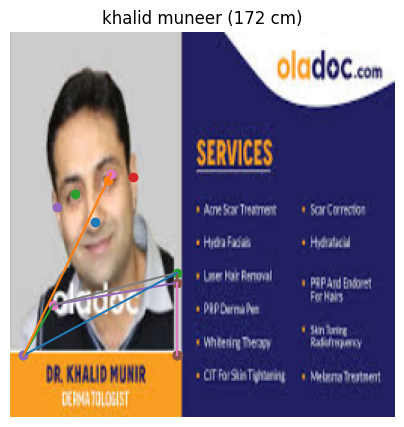

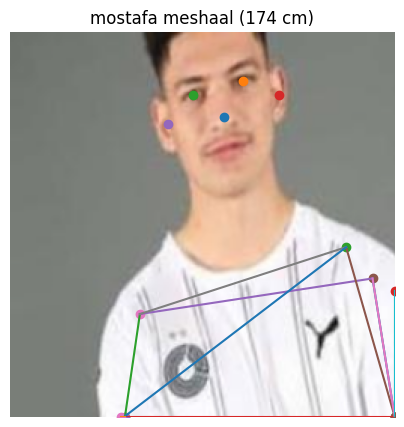

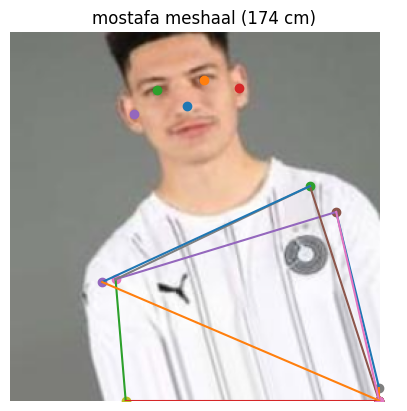

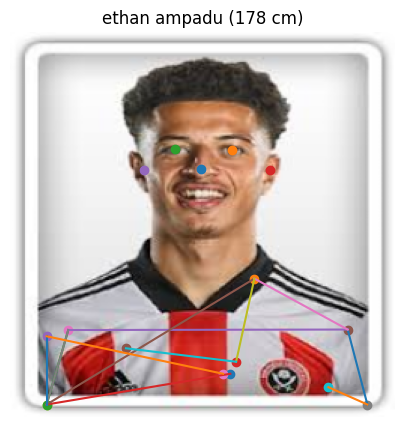

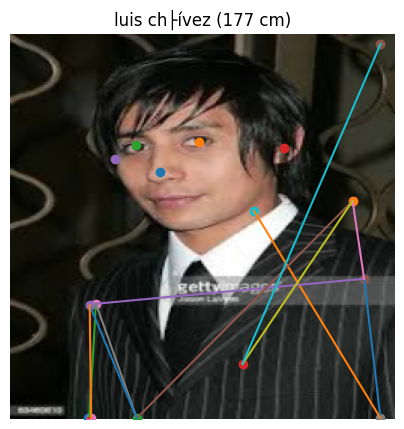

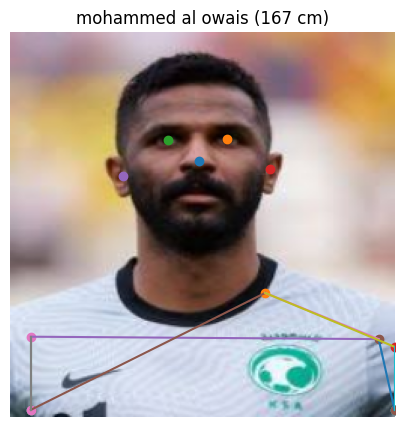

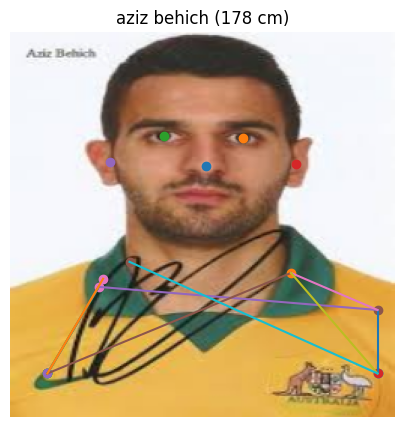

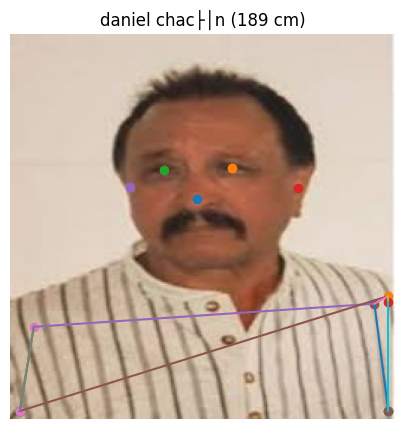

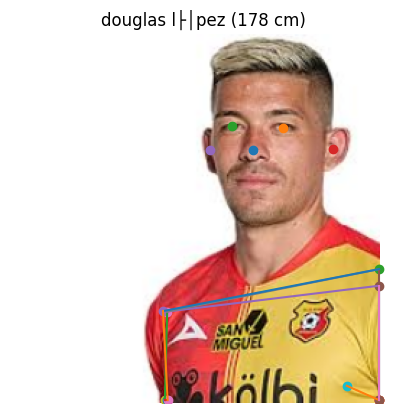

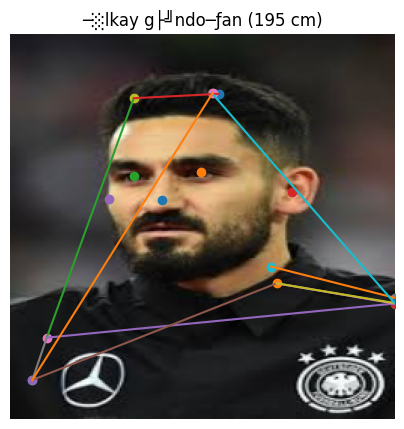

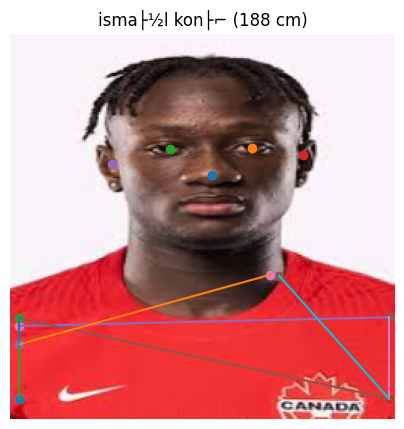

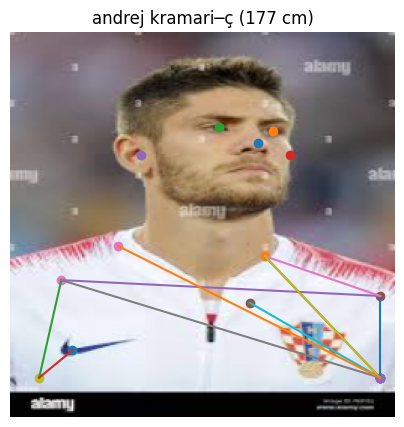

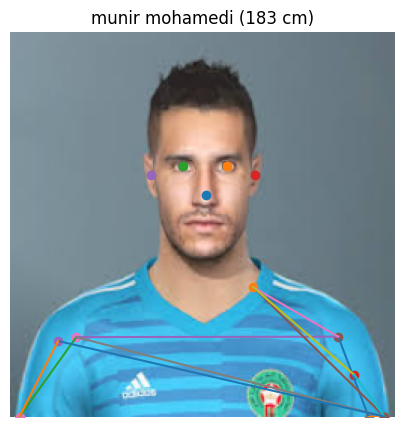

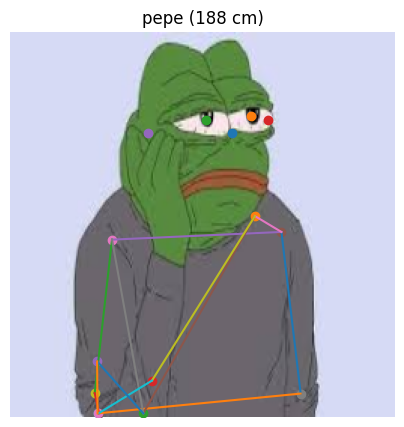

In [22]:
visualize_keypoint_on_img(df_label, "face")

### later simplication into 3 classes (full_body, partial_body, face)
While full-body and face images were classified with reasonable accuracy,
the model showed difficulty distinguishing upper-body and lower-cut poses.

In [3]:
def remap_label(old_label):
    if old_label == "full_body":
        return "full_body"
    elif old_label in ["upper_body", "lower_cut", "full_body_bent"]:
        return "partial_body"
    elif old_label == "face":
        return "face"
    else:
        return None  # malformed or unknown

In [4]:
df_3class = pd.read_csv("fifa_pose_keypoints_labeled.csv")

df_3class["new_label"] = df_3class["label"].apply(remap_label)
df_3class = df_3class.dropna(subset=["new_label"]).reset_index(drop=True)

df_3class.to_csv("fifa_pose_keypoints_3class.csv", index=False)

In [5]:
df_3class["new_label"].value_counts()

new_label
partial_body    815
full_body       336
face             14
Name: count, dtype: int64

In [6]:
len(df_3class)

1165